In [ ]:
import subprocess

package = "torchaudio"
try:
    subprocess.check_call(["pip", "install", package])
except subprocess.CalledProcessError as e:
    print(f"Error installing {package}: {e}")

In [1]:
import numpy as np

In [7]:
%%capture
!pip install datasets==1.14
!pip install transformers==4.11.3
!pip install librosa

In [8]:
from transformers import AutoFeatureExtractor

In [ ]:
!pip install -U sentence-transformers

In [1]:
import torch
import numpy as np
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score
from dataloader import ESC_TL_Dataset_wav2vec
from transformers import Wav2Vec2ForSequenceClassification, Wav2Vec2Processor

: 

: 

In [16]:
# Initialize the pre-trained model and processor

label_map = {'dog': 0, 'rooster': 1, 'pig': 2, 'cow': 3, 'frog': 4, 'cat': 5, 'hen': 6, 'insects': 7,
                'sheep': 8, 'crow': 9, 'rain': 10, 'sea_waves': 11, 'crackling_fire': 12, 'crickets': 13, 'chirping_birds': 14, 'water_drops': 15,
                'wind': 16, 'pouring_water': 17, 'toilet_flush': 18, 'thunderstorm': 19, 'crying_baby': 20, 'sneezing': 21, 'clapping': 22, 'breathing': 23,
                'coughing': 24, 'footsteps': 25, 'laughing': 26, 'brushing_teeth': 27, 'snoring': 28, 'drinking_sipping': 29, 'door_wood_knock': 30, 'mouse_click': 31,
                'keyboard_typing': 32, 'door_wood_creaks': 33, 'can_opening': 34, 'washing_machine': 35, 'vacuum_cleaner': 36, 'clock_alarm': 37, 'clock_tick': 38,
                'glass_breaking': 39, 'helicopter': 40, 'chainsaw': 41, 'siren': 42, 'car_horn': 43, 'engine': 44, 'train': 45, 'church_bells': 46, 'airplane': 47,
                'fireworks': 48, 'hand_saw': 49
            }

class_lookup_35 = {'1': 0, '2': 1, '4': 2, '5': 3, '7': 4, '8': 5, '10': 6, '11': 7, '13': 8, 
                    '14': 9, '15': 10, '16': 11, '17': 12, '18': 13, '20': 14, '22': 15,
                    '25': 16, '26': 17, '27': 18, '28': 19, '29': 20, '30': 21, '31': 22,
                    '32': 23, '33': 24, '34': 25, '35': 26, '38': 27, '40': 28, '41': 29,
                    '42': 30, '43': 31, '45': 32, '48': 33, '49': 34}

# Specify the local file paths for the audio and metadata folders
audio_folder = '/home/almogk/ESC-50-master/audio_16k'
metadata_file = '/home/almogk/ESC-50-master/meta/esc50.csv'

# Initialize the training and validation datasets
train_dataset = ESC_TL_Dataset_wav2vec(audio_folder, metadata_file, label_map, class_lookup_35, 'train')
valid_dataset = ESC_TL_Dataset_wav2vec(audio_folder, metadata_file, label_map, class_lookup_35, 'valid')

# Define the data loaders
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=8, shuffle=False)

In [18]:
model_checkpoint = 'facebook/wav2vec2-base'
model = Wav2Vec2ForSequenceClassification.from_pretrained(model_checkpoint)
processor = Wav2Vec2Processor.from_pretrained(model_checkpoint)
# processor = AutoFeatureExtractor.from_pretrained(model_checkpoint)

# Define the optimizer and loss function
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)
loss_fn = torch.nn.CrossEntropyLoss()


Some weights of the model checkpoint at facebook/wav2vec2-base were not used when initializing Wav2Vec2ForSequenceClassification: ['project_hid.weight', 'project_q.bias', 'project_q.weight', 'project_hid.bias', 'quantizer.weight_proj.bias', 'quantizer.codevectors', 'quantizer.weight_proj.weight']
- This IS expected if you are initializing Wav2Vec2ForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing Wav2Vec2ForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of Wav2Vec2ForSequenceClassification were not initialized from the model checkpoint at facebook/wav2vec2-base and are newly initialized: ['projector.weight', 'classifier.bias', 'projector.

In [ ]:
# Fine-tune the model
for epoch in range(5):
    model.train()
    for audio, label in train_loader:
        
        inputs = processor(audio)
        
        logits = model(inputs.input_values, attention_mask=inputs.attention_mask).logits
        loss = loss_fn(logits, label)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()


In [6]:
import random
import librosa
import IPython
import torchaudio
import numpy as np
import pandas as pd
import os, csv, json
import seaborn as sns
import torch, torchaudio, timm
import matplotlib.pyplot as plt
import infering as infer
from ast_models import ASTModel
from torch.cuda.amp import autocast
import cosin_calc as cc


In [76]:
save_file_path = '/home/almogk/FSL_TL_E_C/data/FSL_SETS/5w_1s_shot/test/15000/'
file_path = 'data_eval.json'

# write the dictionary to a JSON file
with open(save_file_path + file_path, 'r') as f:
    data_eval = json.load(f)

In [3]:
def calculate_fbank_mean_std(folder_path, sample_rate=16000, num_mel_bins=128, frame_shift=10):
    # Initialize lists to store the filterbank features
    fbanks = []

    # Iterate through the folder and load each audio file
    for filename in os.listdir(folder_path):
        if filename.endswith('.wav'):
            file_path = os.path.join(folder_path, filename)

            # Load the audio file
            waveform, _ = torchaudio.load(file_path)

            # Compute the filterbank features
            fbank = torchaudio.compliance.kaldi.fbank(waveform,
                                                      htk_compat=True,
                                                      sample_frequency=sample_rate,
                                                      use_energy=False,
                                                      window_type='hanning',
                                                      num_mel_bins=num_mel_bins,
                                                      dither=0.0,
                                                      frame_shift=frame_shift)

            # Append the filterbank features to the list
            fbanks.append(fbank)

    # Stack the filterbank features and calculate the mean and standard deviation
    fbanks = torch.stack(fbanks, axis=0)
    mean = torch.mean(fbanks)
    std = torch.std(fbanks)

    return mean.item(), std.item()

In [ ]:
# Replace 'audio_files_folder' with the path to your folder containing the audio files
mean, std = calculate_fbank_mean_std(r'ESC-50-master\audio_16k')
print("Filterbank mean:", mean)
print("Filterbank standard deviation:", std)

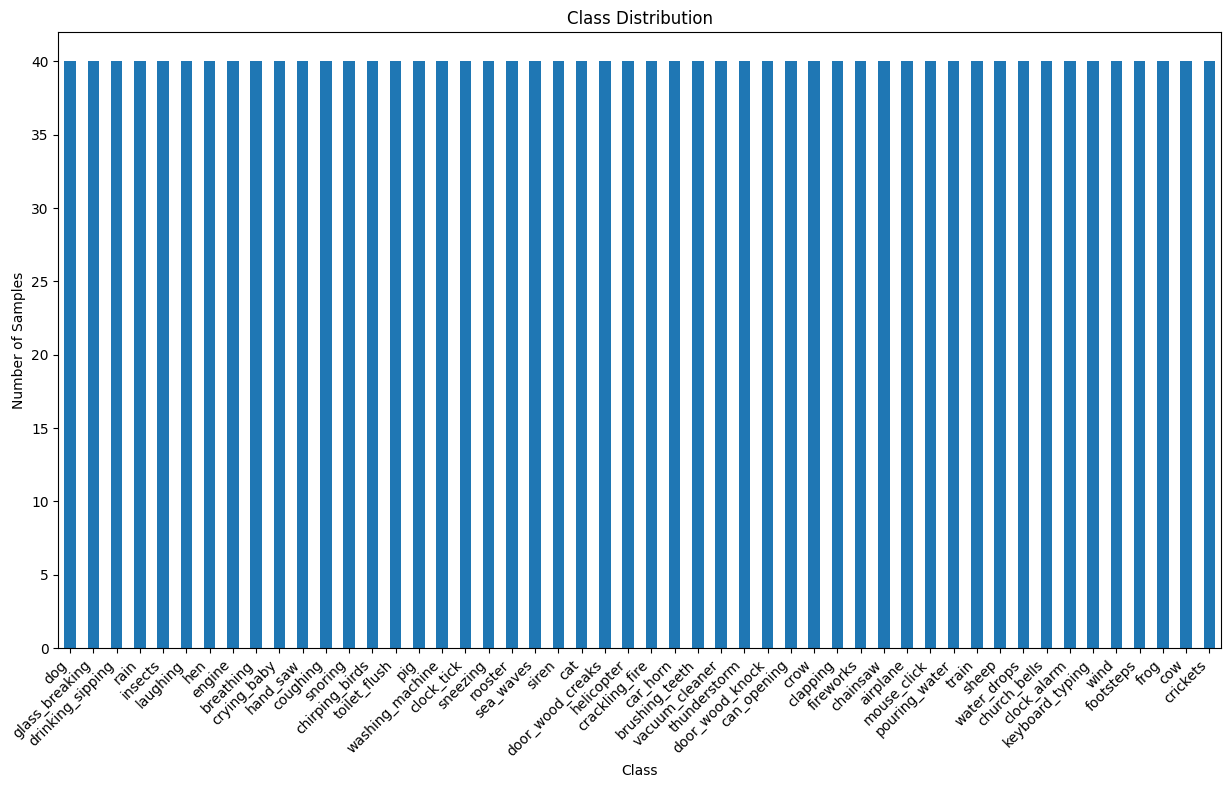

In [16]:
# Load the CSV table ESC-50-master/meta
data = pd.read_csv('/home/almogk/ESC-50-master/meta/esc50.csv')

# Count the number of samples in each class
class_counts = data['category'].value_counts()

plt.figure(figsize=(15, 8))
# Plot a bar chart of the class distribution
class_counts.plot(kind='bar')
plt.title('Class Distribution')
plt.xlabel('Class')
plt.ylabel('Number of Samples')
plt.xticks(rotation=45, ha='right')  # Set the X-axis labels at a 45-degree angle
plt.show()

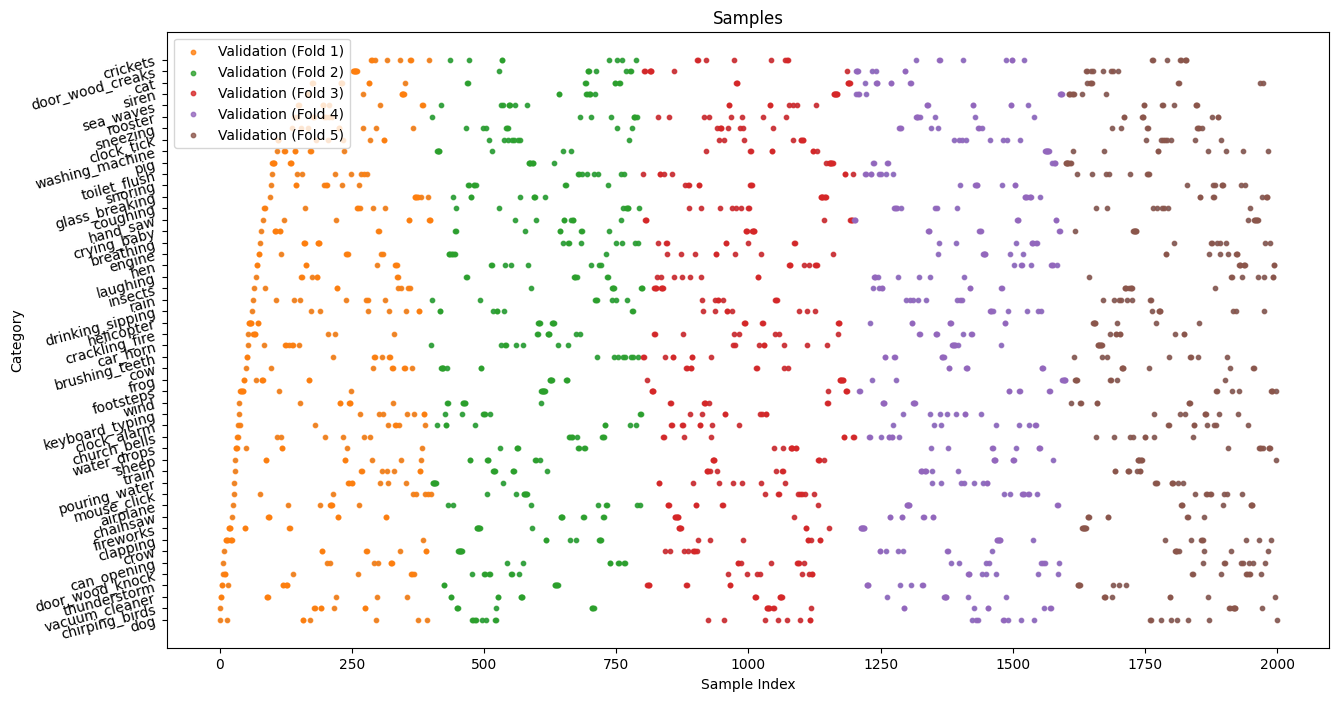

In [18]:
# Create a new scatter plot
fig, ax = plt.subplots(figsize=(15, 8))
ax.scatter(data.index, data['category'], s=5, alpha=0.5)

# Loop over each fold
for i in range(1, 6):
    # Load the fold information
    validation_data = data[data['fold'] == i]
    training_data = data[data['fold'] != i]

    # Identify overlapping samples between training and validation sets
    overlapping_samples = validation_data[validation_data['filename'].isin(training_data['filename'])]

    # Mark the training and validation samples for this fold
    # ax.scatter(training_data.index, training_data['category'], s=10, alpha=0.8, label=f'Training (Fold {i})', color=f'C{i}')
    ax.scatter(validation_data.index, validation_data['category'], s=10, alpha=0.8, label=f'Validation (Fold {i})', color=f'C{i}')

    # Mark the overlapping samples
    if len(overlapping_samples) > 0:
        ax.scatter(overlapping_samples.index, overlapping_samples['category'], s=10, alpha=0.8, label='Overlap', color='black')

# Set the axis labels and legend
ax.set_xlabel('Sample Index')
ax.set_ylabel('Category')
plt.yticks(rotation=15, ha='right')  # Set the X-axis labels at a 45-degree angle
ax.set_title('Samples')
ax.legend()
plt.show()

In [ ]:
# Loop over each fold
for i in range(1, 6):
    # Create a new scatter plot for this fold
    fig, ax = plt.subplots(figsize=(15, 8))
    ax.scatter(data.index, data['category'], s=5, alpha=0.5)

    # Load the fold information
    validation_data = data[data['fold'] == i]
    training_data = data[data['fold'] != i]

    # Identify overlapping samples between training and validation sets
    overlapping_samples = validation_data[validation_data['filename'].isin(training_data['filename'])]

    # Mark the training and validation samples for this fold
    ax.scatter(training_data.index, training_data['category'], s=10, alpha=0.8, label=f'Training (Fold {i})')
    ax.scatter(validation_data.index, validation_data['category'], s=10, alpha=0.8, label=f'Validation (Fold {i})')

    # Mark the overlapping samples
    if len(overlapping_samples) > 0:
        ax.scatter(overlapping_samples.index, overlapping_samples['category'], s=10, alpha=0.8, label='Overlap')

    # Set the axis labels and legend
    ax.set_xlabel('Sample Index')
    ax.set_ylabel('Category')
    plt.yticks(rotation=15, ha='right')  # Set the X-axis labels at a 45-degree angle
    ax.set_title(f'Fold {i} Samples')
    ax.legend()
plt.show()

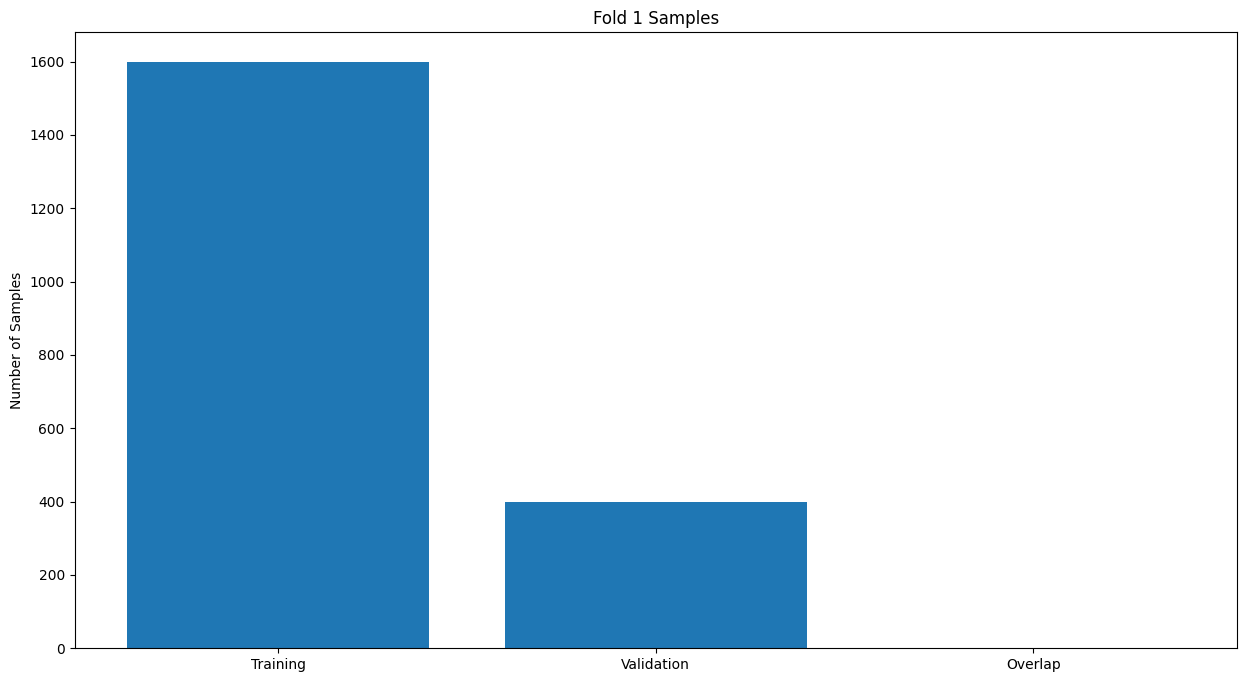

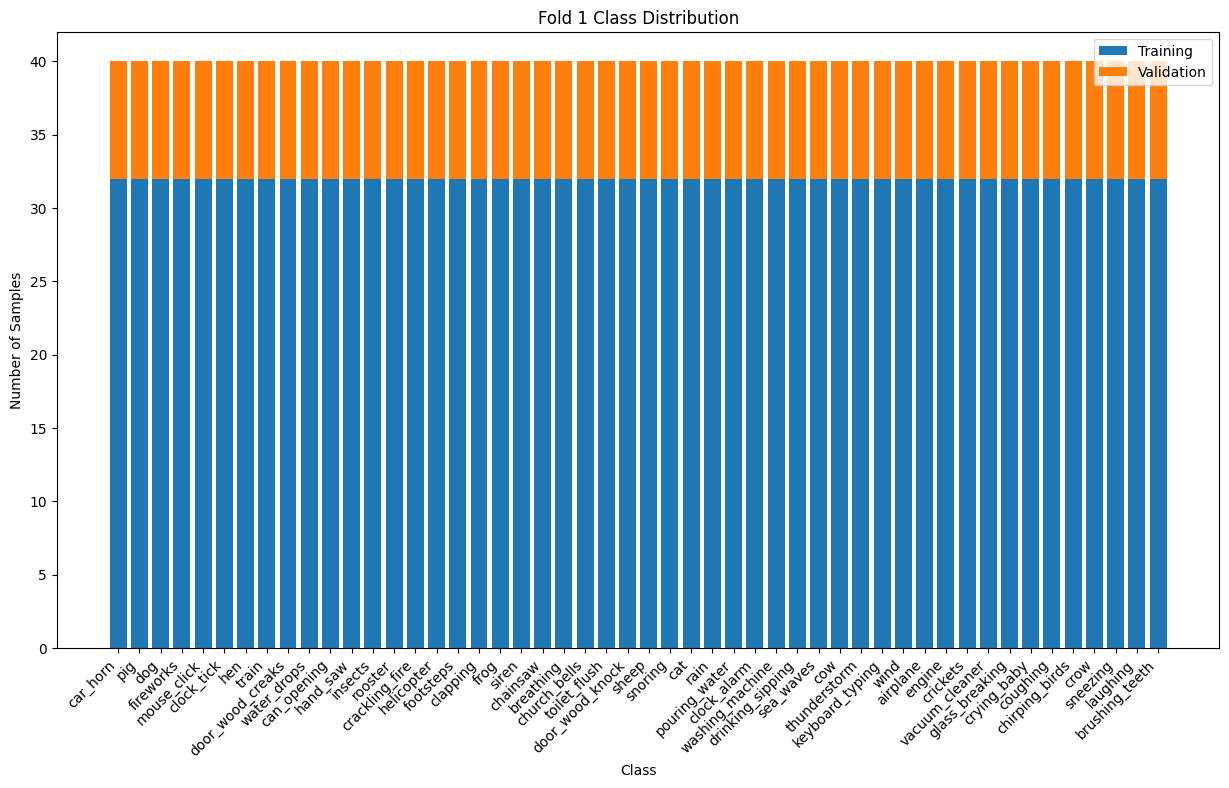

In [20]:
# Loop over each fold
for i in range(1, 2):
    # Create a new figure and axis for this fold
    fig, ax = plt.subplots(figsize=(15, 8))

    # Load the fold information
    validation_data = data[data['fold'] == i]
    training_data = data[data['fold'] != i]

    # Identify overlapping samples between training and validation sets
    overlapping_samples = validation_data[validation_data['filename'].isin(training_data['filename'])]

    # Count the number of training, validation, and overlapping samples
    training_count = len(training_data)
    validation_count = len(validation_data)
    overlap_count = len(overlapping_samples)

    # Plot a bar chart of the sample counts
    ax.bar(['Training', 'Validation', 'Overlap'], [training_count, validation_count, overlap_count])
    ax.set_title(f'Fold {i} Samples')
    ax.set_ylabel('Number of Samples')
    plt.show()

# Loop over each fold and display the training and validation class distribution
for i in range(1, 2):
    # Load the fold information
    validation_data = data[data['fold'] == i]
    training_data = data[data['fold'] != i]
    
    # Count the number of samples in each class
    class_counts = validation_data['category'].value_counts()
    
    # Count the number of samples in each training class
    training_counts = training_data['category'].value_counts()
    
    # Count the number of samples in each validation class
    validation_counts = validation_data['category'].value_counts()
    
    # Plot a bar chart of the training and validation class distribution
    fig, ax = plt.subplots(figsize=(15, 8))
    ax.bar(training_counts.index, training_counts.values, label='Training')
    ax.bar(validation_counts.index, validation_counts.values, bottom=training_counts.values, label='Validation')
    ax.set_title(f'Fold {i} Class Distribution')
    ax.set_xlabel('Class')
    ax.set_ylabel('Number of Samples')
    plt.xticks(rotation=45, ha='right')  # Set the X-axis labels at a 45-degree angle
    ax.legend()
    plt.show()

In [37]:
def read_csv_from_folder(folder_path, COLUMN_NAMES):
    results = []
    for fold in os.listdir(folder_path):
        fold_path = os.path.join(folder_path, fold)
        if os.path.isdir(fold_path):
            result_file = os.path.join(fold_path, 'result.csv')
            if os.path.isfile(result_file):
                results.append(pd.read_csv(result_file, header=None, names=COLUMN_NAMES))
    return results


def plot_accuracy(models, models_names, base_path, COLUMN_NAMES):
    accuracies = []
    for i, model in enumerate(models):
        folder_path = os.path.join(base_path, model)
        model_results = read_csv_from_folder(folder_path, COLUMN_NAMES)
        model_best_acc = [result['acc'].max() for result in model_results]
        mean_acc = np.mean(model_best_acc)
        std_acc = np.std(model_best_acc)
        accuracies.append((models_names[i], mean_acc, std_acc))
    
    fig, ax = plt.subplots(figsize=(15, 5))
    bars = ax.bar([x[0] for x in accuracies], [x[1] for x in accuracies], color=plt.cm.tab20.colors[:len(models)])
    ax.set_xlabel('Models')
    ax.set_ylabel('Accuracy')
    ax.set_title('Accuracy of Models (mean and std deviation)')
    
    # Add the mean and std deviation text above the columns
    for bar, acc in zip(bars, accuracies):
        ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.005, f'{acc[1]:.2f}±{acc[2]:.2f}', ha='center', va='bottom', fontsize=9)
    
    plt.xticks(rotation=45)
    plt.show()

def plot_losses(models, models_names, base_path, COLUMN_NAMES):
    for i, model in enumerate(models):
        folder_path = os.path.join(base_path, model)
        model_results = read_csv_from_folder(folder_path, COLUMN_NAMES)
        avg_losses = pd.concat(model_results).groupby(level=0).mean()
        epochs = range(1, len(avg_losses) + 1)

        fig, ax = plt.subplots(figsize=(5, 4))
        ax.plot(epochs, avg_losses['loss_meter'], label='Training Loss')
        ax.plot(epochs, avg_losses['valid_loss'], label='Validation Loss')
        ax.set_xlabel('Epochs')
        ax.set_ylabel('Loss')
        ax.set_title(f'{models_names[i]} - Average Training and Validation Loss')
        ax.legend()
        plt.show()

def plot_accuracies_and_losses(models, models_names, base_path, COLUMN_NAMES):
    accuracies = []
    losses = []
    
    for i, model in enumerate(models):
        folder_path = os.path.join(base_path, model)
        model_results = read_csv_from_folder(folder_path, COLUMN_NAMES)
        
        # Compute accuracy statistics
        model_best_acc = [result['acc'].max() for result in model_results]
        mean_acc = np.mean(model_best_acc)
        std_acc = np.std(model_best_acc)
        accuracies.append((models_names[i], mean_acc, std_acc))
        
        # Compute loss statistics
        avg_losses = pd.concat(model_results).groupby(level=0).mean()
        epochs = range(1, len(avg_losses) + 1)
        losses.append((epochs, avg_losses['loss_meter'], avg_losses['valid_loss']))
    
    # Plot accuracies
    fig, ax = plt.subplots(figsize=(27, 5))
    bars = ax.bar([x[0] for x in accuracies], [x[1] for x in accuracies], color=plt.cm.tab20.colors[:len(models)])
    ax.set_xlabel('Models')
    ax.set_ylabel('Accuracy')
    ax.set_title('Accuracy and Losses of Models (mean and std deviation)')
    
    # Add the mean and std deviation text above the columns
    for bar, acc in zip(bars, accuracies):
        ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.005, f'{acc[1]:.2f}±{acc[2]:.2f}', ha='center', va='bottom', fontsize=9)
    
    # plt.xticks(rotation=25)
    
    # Plot losses for each model in a row
    fig, axes = plt.subplots(nrows=1, ncols=len(models), figsize=(22, 3))
    for i, ax in enumerate(axes):
        epochs, train_loss, val_loss = losses[i]
        ax.plot(epochs, train_loss, label='Training Loss')
        ax.plot(epochs, val_loss, label='Validation Loss')
        ax.set_xlabel('Epochs')
        ax.set_ylabel('Loss')
        ax.set_title(f'{models_names[i]} - Average Train\Val Loss')
        ax.legend()
    plt.tight_layout()
    plt.show()

In [38]:
COLUMN_NAMES = ['acc', 'mAUC', 'average_precision', 'average_recall', 'd_prime_mAUC', 'loss_meter', 'valid_loss',
                 'cum_acc', 'cum_mAUC', 'optimizer_lr']

base_path = 'ast_class_exp'  # Set the path to the experiments folder
models = [model for model in os.listdir(base_path)]
models.sort()

models_names = ['scratch T(ESC-35)', 'PT(ImagNet) FT(ESC-35)', 'PT(ImagNet, AudioSet) FT(ESC-35)']

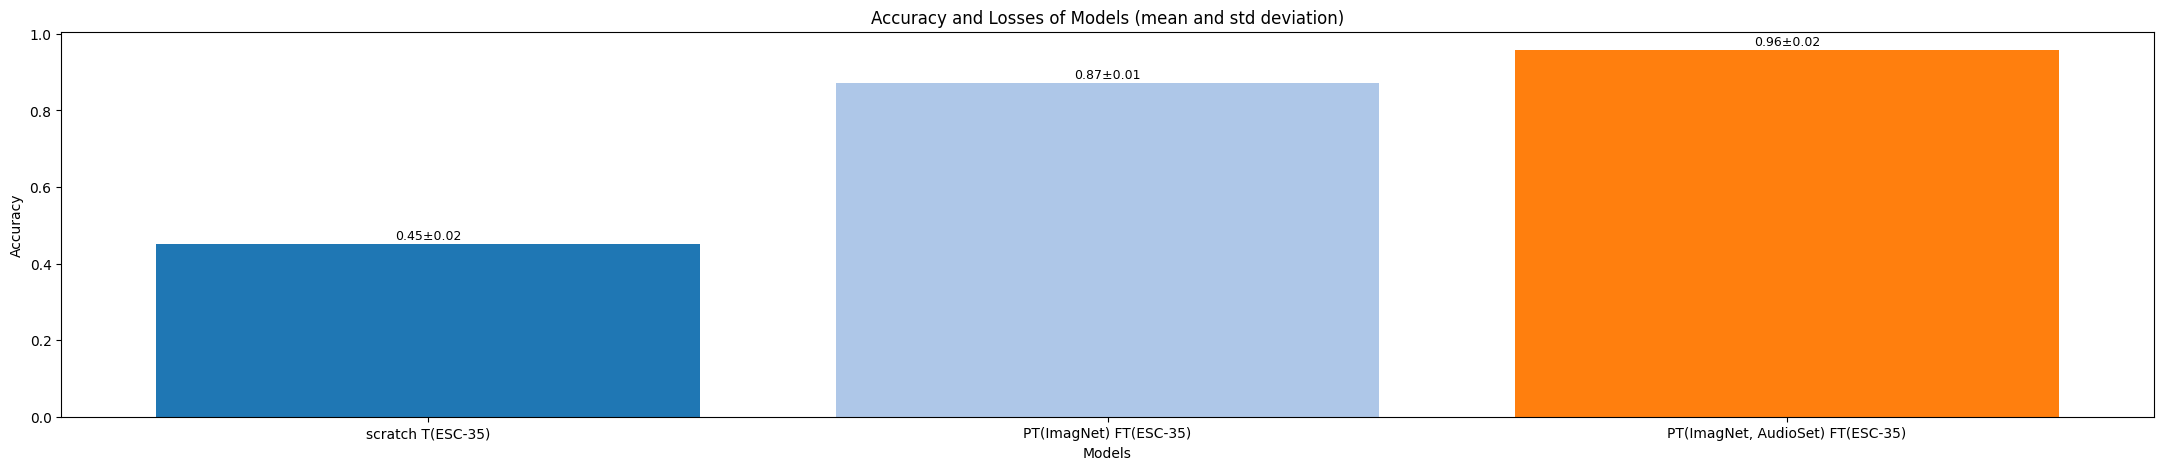

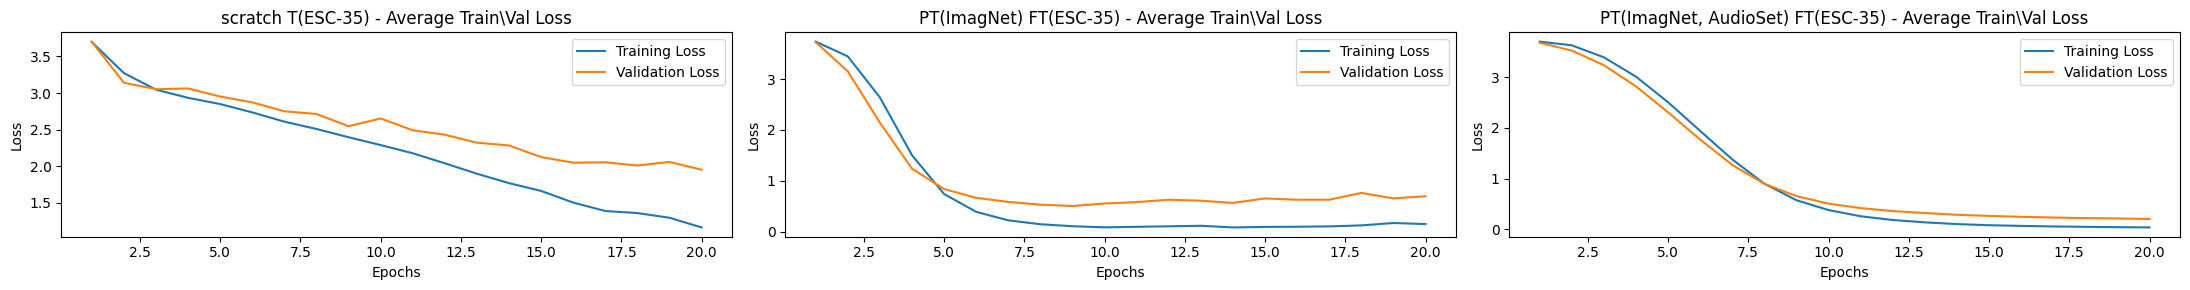

In [74]:
plot_accuracies_and_losses(models, models_names, base_path, COLUMN_NAMES)

In [ ]:
plot_accuracies_and_losses(models, models_names, base_path, COLUMN_NAMES)

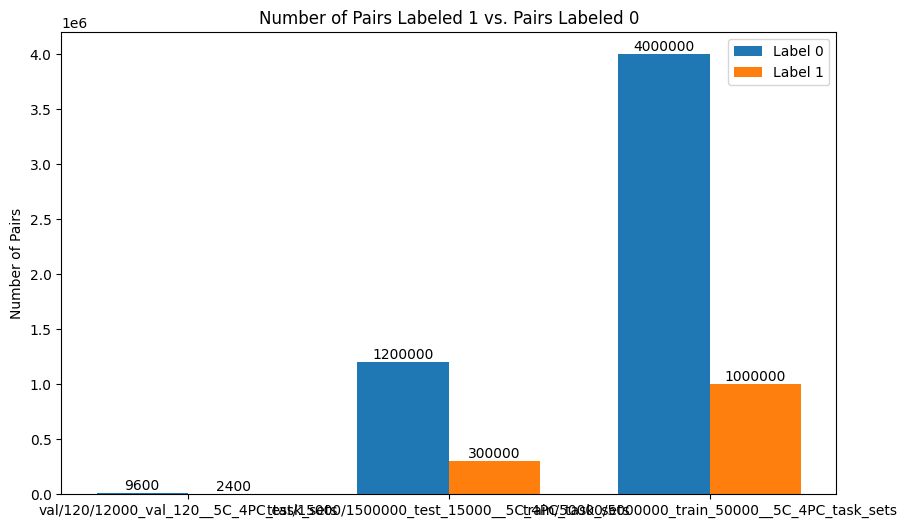

In [11]:
data_folder = '/home/almogk/FSL_TL_E_C/data/FSL_SETS/5w_1s_shot/'  # Set the path to the data folder
file_names = ['val/120/12000_val_120__5C_4PC_task_sets.json', 'test/15000/1500000_test_15000__5C_4PC_task_sets.json', 'train/50000/5000000_train_50000__5C_4PC_task_sets.json']

plot_labels(data_folder, file_names)

In [7]:
def balance_labels_good(file_path, num_folds):
    with open(file_path, 'r') as f:
        data = json.load(f)

    label_0 = [item for item in data if item[0] == 0]
    label_1 = [item for item in data if item[0] == 1]

    num_ones = len(label_1)
    num_zeros = len(label_0)

    # Create a list of zeros for each fold
    zero_folds = [[] for _ in range(num_folds)]
    fold_size = num_zeros // num_folds
    for i in range(num_folds):
        fold_start = i * fold_size
        fold_end = (i + 1) * fold_size
        zero_folds[i] = label_0[fold_start:fold_end]

    # Distribute the ones evenly across all folds
    one_folds = [[] for _ in range(num_folds)]
    fold_size = num_ones // num_folds
    for i in range(num_folds):
        fold_start = i * fold_size
        fold_end = (i + 1) * fold_size
        one_folds[i] = label_1

    # Combine the one and zero folds
    folds = [one_folds[i] + zero_folds[i] for i in range(num_folds)]

    return folds

def balance_labels(file_path, num_folds):
    with open(file_path, 'r') as f:
        data = json.load(f)

    label_0 = [item for item in data if item[0] == 0]
    label_1 = [item for item in data if item[0] == 1]

    # Balance the number of 0's to match the number of 1's
    random.shuffle(label_0)
    label_0 = label_0[:len(label_1)]

    balanced_data = label_0 + label_1
    random.shuffle(balanced_data)

    fold_size = len(balanced_data) // num_folds
    folds = [balanced_data[i * fold_size:(i + 1) * fold_size] for i in range(num_folds)]

    return folds

def create_balanced_files(data_folder, file_names, num_folds=4):

    for file_name in file_names:
        file_path = os.path.join(data_folder, file_name)
        balanced_folds = balance_labels_good(file_path, num_folds)

        for i, fold in enumerate(balanced_folds):
            new_file_name = f"{file_name[:-5]}_balanced_fold_{i + 1}.json"
            new_file_path = os.path.join(data_folder, new_file_name)
            with open(new_file_path, 'w') as f:
                json.dump(fold, f, indent=4)

def count_labels(file_path):
    with open(file_path, 'r') as f:
        data = json.load(f)

    count_0 = sum([1 for item in data if item[0] == 0])
    count_1 = sum([1 for item in data if item[0] == 1])

    return count_0, count_1

def plot_labels(data_folder, file_prefixes, num_folds=4):

    for prefix in file_prefixes:
        counts = []

        for i in range(1, num_folds + 1):
            file_name = f"{prefix}_balanced_fold_{i}.json"
            file_path = os.path.join(data_folder, file_name)
            count_0, count_1 = count_labels(file_path)
            counts.append((file_name[:-5], count_0, count_1))

        fig, ax = plt.subplots(figsize=(10, 6))

        x = np.arange(num_folds)
        width = 0.35

        bars_0 = ax.bar(x - width / 2, [x[1] for x in counts], width, label='Label 0')
        bars_1 = ax.bar(x + width / 2, [x[2] for x in counts], width, label='Label 1')

        ax.set_ylabel('Number of Pairs')
        ax.set_title(f'{prefix.capitalize()} Data: Number of Pairs Labeled 1 vs. Pairs Labeled 0')
        ax.set_xticks(x)
        ax.set_xticklabels([f"Fold {i}" for i in range(1, num_folds + 1)])
        ax.legend(loc='lower left')

        # Add the numbers above the bars
        for bars in (bars_0, bars_1):
            for bar in bars:
                ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.5, str(int(bar.get_height())), ha='center', va='bottom')

        plt.show()


In [8]:
data_folder = '/home/almogk/FSL_TL_E_C/data/FSL_SETS/5w_1s_shot/train/5000/'  # Set the path to the data folder FSL_TL_E_C/data/.json
file_names = ['25000_train_5000__1C_1PC_task_sets.json']

create_balanced_files(data_folder, file_names)

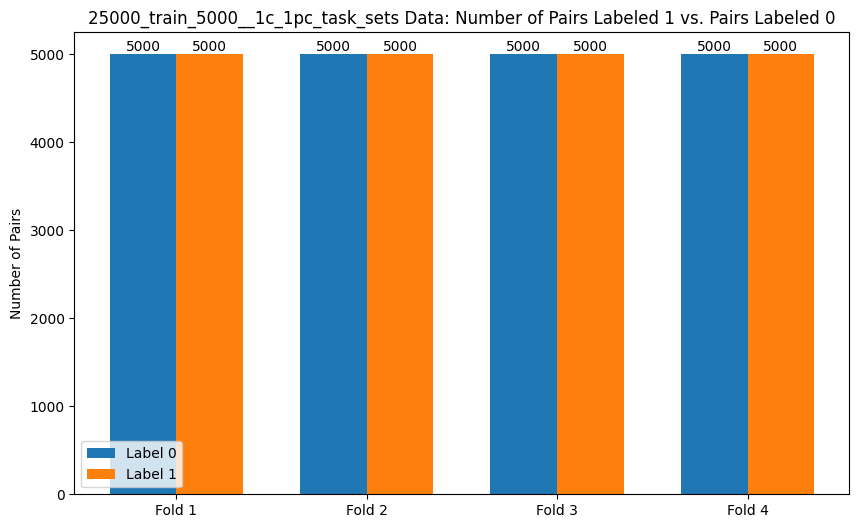

In [9]:
data_folder = '/home/almogk/FSL_TL_E_C/data/FSL_SETS/5w_1s_shot/train/5000/'  # Set the path to the data folder FSL_TL_E_C/data/.json
file_names = ['25000_train_5000__1C_1PC_task_sets']

plot_labels(data_folder, file_names)

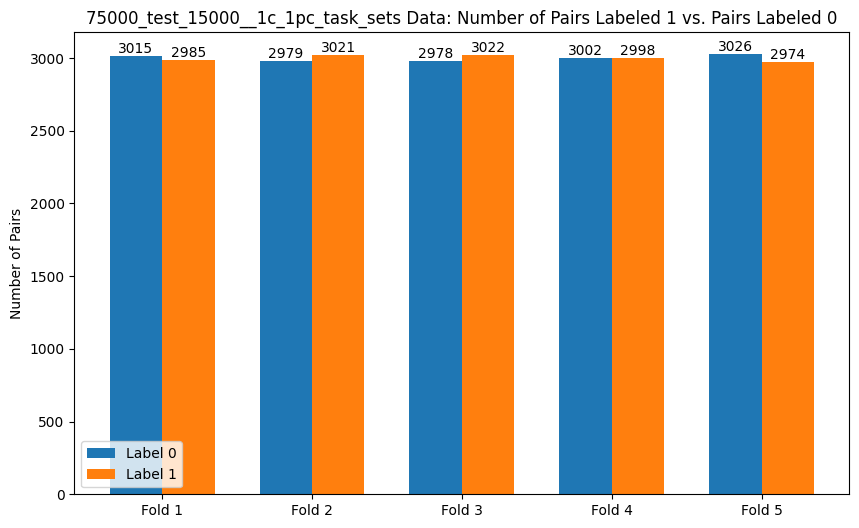

In [83]:
data_folder = '/home/almogk/FSL_TL_E_C/data/FSL_SETS/5w_1s_shot/test/15000/'  # Set the path to the data folder FSL_TL_E_C/data/.json
file_names = ['75000_test_15000__1C_1PC_task_sets']

plot_labels(data_folder, file_names)

In [ ]:
/home/almogk/FSL_TL_E_C/data/FSL_SETS/5w_1s_shot/test/15000/150000_test_15000_ss_task_sets.json

In [11]:
with open('/home/almogk/FSL_TL_E_C/data/FSL_SETS/5w_1s_shot/test/embeddings___test_output.json', 'r') as f:
    embeddings_full = json.load(f)
    embeddings_full = {key: np.array(value) for key, value in embeddings_full.items()}

In [12]:
with open('/home/almogk/FSL_TL_E_C/data/FSL_SETS/5w_1s_shot/test/15000/150000_test_15000_ss_task_sets.json', 'r') as f:
    pairs = json.load(f)

In [13]:
cosine_distances = cc.calculate_cosine_distances(embeddings_full, pairs)

In [ ]:
perso_ss_tresholds = cc.make_perso_ss_tresholds_openset(cosine_distances)

In [54]:
len(embeddings_full['/home/almogk/ESC-50-master/audio_16k/1-100032-A-0.wav'])

6

In [48]:
cosine_distances = cc.calculate_cosine_distances(embeddings_full, pairs)

In [56]:
cosine_distances[1]

[0.3785385509937488,
 0.19001626003010408,
 0.75165211696258,
 0.44095328861068306,
 0.7653869767874564,
 0.6306662115830066]

In [64]:
stats_labeled_1, stats_labeled_0, stats_labeled = cc.calculate_statistics(cosine_distances, pairs, labeled_file='/home/almogk/FSL_TL_E_C/data/FSL_SETS/5w_1s_shot/test/15000/')

# TO DO: save the cosine dis and anaylze them !!
## parser the balance 1/0 and not balance !!
classifications_repo_mc, accuracies_b, accuracies_mc, conf_matrices_mc, reports_b, mc_p, conf_matrices_b = cc.evaluate_classification(cosine_distances, pairs)

In [68]:
stats_labeled['dist_0']

{'mean': 0.5644930411802952,
 'std': 0.4299809279737293,
 'min': -0.26284194757635415,
 'max': 0.9996449027079313,
 'median': 0.7586628198048471,
 'q1': 0.14604727456635366,
 'q3': 0.9517992458883104}

In [61]:
conf_matrices_b[0]

array([[1588, 1390],
       [ 685, 2337]])

In [62]:
reports_b[0]

{'0': {'precision': 0.6986361636603607,
  'recall': 0.5332437877770315,
  'f1-score': 0.6048371738716435,
  'support': 2978},
 '1': {'precision': 0.6270458814059565,
  'recall': 0.7733289212442092,
  'f1-score': 0.6925470440065195,
  'support': 3022},
 'accuracy': 0.6541666666666667,
 'macro avg': {'precision': 0.6628410225331587,
  'recall': 0.6532863545106203,
  'f1-score': 0.6486921089390815,
  'support': 6000},
 'weighted avg': {'precision': 0.6625785248315591,
  'recall': 0.6541666666666667,
  'f1-score': 0.6490137117962427,
  'support': 6000}}

In [ ]:
file_prefixes = ['75000_test_15000__1C_1PC_task_sets']

plot_labels(data_folder, file_prefixes)

In [3]:
# Create a new class that inherits the original ASTModel class
class ASTModelVis(ASTModel):
    def get_att_map(self, block, x):
        qkv = block.attn.qkv
        num_heads = block.attn.num_heads
        scale = block.attn.scale
        B, N, C = x.shape
        qkv = qkv(x).reshape(B, N, 3, num_heads, C // num_heads).permute(2, 0, 3, 1, 4)
        q, k, v = qkv[0], qkv[1], qkv[2]  # make torchscript happy (cannot use tensor as tuple)
        attn = (q @ k.transpose(-2, -1)) * scale
        attn = attn.softmax(dim=-1)
        return attn

    def forward_visualization(self, x):
        # expect input x = (batch_size, time_frame_num, frequency_bins), e.g., (12, 1024, 128)
        x = x.unsqueeze(1)
        x = x.transpose(2, 3)

        B = x.shape[0]
        x = self.v.patch_embed(x)
        cls_tokens = self.v.cls_token.expand(B, -1, -1)
        dist_token = self.v.dist_token.expand(B, -1, -1)
        x = torch.cat((cls_tokens, dist_token, x), dim=1)
        x = x + self.v.pos_embed
        x = self.v.pos_drop(x)
        
        # save the attention map of each of 12 Transformer layer
        att_list = []
        for blk in self.v.blocks:
            cur_att = self.get_att_map(blk, x)
            att_list.append(cur_att)
            x = blk(x)
        
        # v_e = x.clone()
        
        x = self.v.norm(x)
        x = (x[:, 0] + x[:, 1]) / 2
        
        v_e = x.clone()
        
        x = self.mlp_head(x)
        
        return att_list, v_e, x

def make_features(wav_name, mel_bins, target_length):
    waveform, sr = torchaudio.load(wav_name)
    assert sr == 16000, 'input audio sampling rate must be 16kHz'

    fbank = torchaudio.compliance.kaldi.fbank(
        waveform, htk_compat=True, sample_frequency=sr, use_energy=False,
        window_type='hanning', num_mel_bins=mel_bins, dither=0.0, frame_shift=10)

    n_frames = fbank.shape[0]

    p = target_length - n_frames
    if p > 0:
        m = torch.nn.ZeroPad2d((0, 0, 0, p))
        fbank = m(fbank)
    elif p < 0:
        fbank = fbank[0:target_length, :]

    fbank = (fbank - (-6.6268077)) / (5.358466 * 2)
    return fbank

def load_label(label_csv):
    with open(label_csv, 'r') as f:
        reader = csv.reader(f, delimiter=',')
        lines = list(reader)
    labels = []
    ids = []  # Each label has a unique id such as "/m/068hy"
    for i1 in range(1, len(lines)):
        id = lines[i1][1]
        label = lines[i1][2]
        ids.append(id)
        labels.append(label)
    return labels

In [ ]:
11/2-2

In [204]:
# audioset input sequence length is 1024
pretrained_mdl_path = '/home/almogk/FSL_TL_E_C/pretraind_models/audioset_10_10_0.4593.pth'

# get the frequency and time stride of the pretrained model from its name
fstride, tstride = int(pretrained_mdl_path.split('/')[-1].split('_')[1]), int(pretrained_mdl_path.split('/')[-1].split('_')[2].split('.')[0])

# The input of audioset pretrained model is 1024 frames.
input_tdim = 1024


In [205]:

# initialize an AST model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
sd = torch.load(pretrained_mdl_path, map_location=device)
audio_mo = ASTModel(label_dim=527, input_tdim=input_tdim, fstride=fstride, tstride=tstride)
audio_mo = torch.nn.DataParallel(audio_mo)
audio_mo.load_state_dict(sd, strict=False)

In [ ]:
'module.v.pos_embed'
'module.mlp_head.1.weight'
'module.mlp_head.1.bias'

In [207]:
pretrained_state_dict = audio_mo.state_dict()

In [209]:
pretrained_state_dict.keys()

In [202]:
sample_audio_path = '/home/almogk/ESC-50-master/audio_16k/4-117627-A-25.wav'

feats = make_features(sample_audio_path, mel_bins=128, target_length=input_tdim)  # shape(512, 128)
feats_data = feats.expand(1, input_tdim, 128)           # reshape the feature
feats_data = feats_data.to(torch.device("cuda:0"))

# Make the prediction
with torch.no_grad():
  with autocast():
    x_m, v_e_m= audio_mo.forward(feats_data)
    output = torch.sigmoid(x_m)


result_output = output.data.cpu().numpy()[0]
sorted_indexes = np.argsort(result_output)[::-1]
# # Print audio tagging top probabilities
# print('Predice results:')
# for k in range(len(sorted_indexes)):
#     print('- {}: {:.4f}'.format(np.array(labels)[sorted_indexes[k]], result_output[sorted_indexes[k]]))

print('Listen to this sample: ')
IPython.display.Audio(sample_audio_path)

In [20]:
# Assume each input spectrogram has 1024 time frames
input_tdim = 512

# 
# now load the visualization model
ast_mdl = ASTModelVis(label_dim=35, input_tdim=input_tdim, imagenet_pretrain=True, audioset_pretrain=False)
# ast_mdl = torch.nn.DataParallel(ast_mdl)

# # print(f'[*INFO] load checkpoint: {checkpoint_path}')
# checkpoint_path = '/home/almogk/FSL_TL_E_C/ast_class_exp/10/4/models/best_audio_model.pth'
# checkpoint = torch.load(checkpoint_path, map_location='cuda')

audio_model = torch.nn.DataParallel(ast_mdl, device_ids=[0])
# audio_model.load_state_dict(checkpoint)
audio_model = audio_model.to(torch.device("cuda:0"))
audio_model.eval()          


# Load the AudioSet label set/home/almogk/FSL_TL_E_C/esc_test_class_labels_indices.csv
label_csv = '/home/almogk/FSL_TL_E_C/esc_train_class_labels_indices.csv'       # label and indices for audioset data
labels = infer.load_label(label_csv)


sample_audio_path = '/home/almogk/ESC-50-master/audio_16k/4-117627-A-25.wav'

feats = infer.make_features(sample_audio_path, mel_bins=128, target_length=input_tdim)  # shape(512, 128)
feats_data = feats.expand(1, input_tdim, 128)           # reshape the feature
feats_data = feats_data.to(torch.device("cuda:0"))

# Make the prediction
with torch.no_grad():
  with autocast():
    x_, v_e_= audio_model.forward(feats_data)
    # x_m, v_e_m= audio_mo.forward(feats_data)
  
    _, v_e, x = ast_mdl.forward_visualization(feats_data)
  output = torch.sigmoid(x_)
  output1 = torch.sigmoid(x)

result_output = output.data.cpu().numpy()[0]
sorted_indexes = np.argsort(result_output)[::-1]
# Print audio tagging top probabilities

print('Predice results:')
class_lookup_35 = {'1': 0, '2': 1, '4': 2, '5': 3, '7': 4, '8': 5, '10': 6, '11': 7, '13': 8, 
                    '14': 9, '15': 10, '16': 11, '17': 12, '18': 13, '20': 14, '22': 15,
                    '25': 16, '26': 17, '27': 18, '28': 19, '29': 20, '30': 21, '31': 22,
                    '32': 23, '33': 24, '34': 25, '35': 26, '38': 27, '40': 28, '41': 29,
                    '42': 30, '43': 31, '45': 32, '48': 33, '49': 34}

for k in range(len(sorted_indexes)):
    print('- {}: {:.4f}'.format(np.array(labels)[sorted_indexes[k]], result_output[sorted_indexes[k]]))

print('Listen to this sample: ')
IPython.display.Audio(sample_audio_path)

In [11]:
sorted_indexes

In [183]:
result_output

In [169]:
x

In [140]:

# Get a sample audio and make feature for predict

sample_audio_path = '/home/almogk/ESC-50-master/audio_16k/4-108352-A-33.wav'

feats = make_features(sample_audio_path, mel_bins=128, target_length=input_tdim)  # shape(512, 128)
feats_data = feats.expand(1, input_tdim, 128)           # reshape the feature
feats_data = feats_data.to(torch.device("cuda:0"))
# do some masking of the input
#feats_data[:, :512, :] = 0.

In [141]:
feats_data.size()

In [142]:
# Make the prediction
with torch.no_grad():
  with autocast():
    x_ , v_e_= audio_model.forward(feats_data)
    _, v_e, x = audio_model.module.forward_visualization(feats_data)
  output = torch.sigmoid(x_)
  output1 = torch.sigmoid(x)

result_output = output1.data.cpu().numpy()[0]
sorted_indexes = np.argsort(result_output)[::-1]

In [143]:
output1